In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from IPython import display
import time
import glob

from math import *
import random

def tovar(x):
    return torch.FloatTensor(x).cuda()

In [2]:
#! wget https://github.com/thorsilver/TripletCAEmbedding/raw/master/Results_CellPyLib_Random/triplet_CellLib_random.pth

In [3]:
class Triplet(nn.Module):
    def __init__(self):
        super(Triplet,self).__init__()
        
        self.l1a = nn.Conv3d(3,32,5,padding=2)
        nn.init.orthogonal_(self.l1a.weight, gain=sqrt(2))
        self.b1a = nn.BatchNorm3d(32)
        self.l1b = nn.Conv3d(32,32,5,padding=2)
        self.b1b = nn.BatchNorm3d(32)
        nn.init.orthogonal_(self.l1b.weight, gain=sqrt(2))
        self.p1 = nn.MaxPool3d(2)
        
        self.l2a = nn.Conv3d(32,64,5,padding=2)
        self.b2a = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2a.weight, gain=sqrt(2))
        self.l2b = nn.Conv3d(64,64,5,padding=2)
        self.b2b = nn.BatchNorm3d(64)
        nn.init.orthogonal_(self.l2b.weight, gain=sqrt(2))
        self.p2 = nn.MaxPool3d(2)

        self.l3a = nn.Conv3d(64,128,5,padding=2)
        self.b3a = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3a.weight, gain=sqrt(2))
        self.l3b = nn.Conv3d(128,128,5,padding=2)
        self.b3b = nn.BatchNorm3d(128)
        nn.init.orthogonal_(self.l3b.weight, gain=sqrt(2))
        self.p3 = nn.MaxPool3d(2)
        
        self.l4a = nn.Conv3d(128,256,5,padding=2)
        self.b4a = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4a.weight, gain=sqrt(2))
        self.l4b = nn.Conv3d(256,256,5,padding=2)
        self.b4b = nn.BatchNorm3d(256)
        nn.init.orthogonal_(self.l4b.weight, gain=sqrt(2))
        self.p4 = nn.MaxPool3d(2)
        
        self.l5 = nn.Linear(256,16,1)
        nn.init.orthogonal_(self.l5.weight, gain=sqrt(2))
        
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        z = x
        z = F.leaky_relu(self.l1a(z))
        z = self.b1a(z)
        z = F.leaky_relu(self.l1b(z))
        z = self.b1b(z)
        z = self.p1(z)
        
        z = F.leaky_relu(self.l2a(z))
        z = self.b2a(z)
        z = F.leaky_relu(self.l2b(z))
        z = self.b2b(z)
        z = self.p2(z)
        
        z = F.leaky_relu(self.l3a(z))
        z = self.b3a(z)
        z = F.leaky_relu(self.l3b(z))
        z = self.b3b(z)
        z = self.p3(z)
        
        z = F.leaky_relu(self.l4a(z))
        z = self.b4a(z)
        z = F.leaky_relu(self.l4b(z))
        z = self.b4b(z)
        z = self.p4(z).mean(4).mean(3).mean(2)
        
        z = self.l5(z)
        z = z/torch.sqrt(torch.sum(z**2,1)+1e-4).unsqueeze(1)
        
        return z

In [4]:
def imload(fname):
    im = Image.open(fname)
    im = (np.array(im)-128.0)/128.0
    return im

def loadstack(name_root, maxt=32):
    stack = []
    
    for i in range(maxt):
        stack.append(imload(name_root+"_%.6d.png" % i))
    
    return np.array(stack).transpose(3,1,2,0) # ZR x XR x YR x 3 -> 3 x XR x YR x ZR

def imloadX(fname, x, y):
    im = Image.open(fname)
    im = (np.array(im)-128.0)/128.0
    x0 = x
    y0 = y
    return im[x0:x0+128,y0:y0+128,:]

def getSequence(carule, N=32):
    x1 = []
    
    for init in range(2):
        stack = loadstack("data2_2d/%.6d/%.6d" % (carule, init), maxt=1024)
        subx1 = []
        
        for i in range(N):
            t = int((1024-32)*(i/(N-1)))
            subx1.append(stack[:,:,:,t:t+32])
        x1.append(np.array(subx1))
        
    return np.array(x1) # init x frames x ...

def getBatch(N=20):
    x1 = []
    x2 = []
    x3 = []
    
    for i in range(N):
        c1 = np.random.randint(6000)
        c2 = np.random.randint(6000)
        
        k1 = np.random.randint(20)
        k2 = np.random.randint(20)
        k3 = np.random.randint(20)
        
        x1.append(loadstack("data_2d/%.6d/%.6d" % (c1,k1)))
        x2.append(loadstack("data_2d/%.6d/%.6d" % (c1,k2)))
        x3.append(loadstack("data_2d/%.6d/%.6d" % (c2,k3)))
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    
    return x1,x2,x3

In [5]:
net = Triplet().cuda()
net.load_state_dict(torch.load("triplet_ca_2d.pth"))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

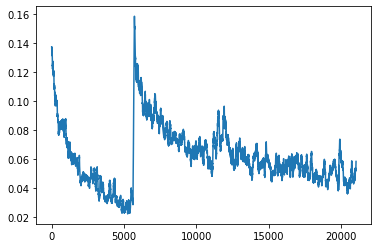

KeyboardInterrupt: 

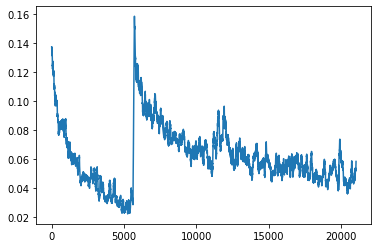

In [82]:
#tr_err = []
lossfn = nn.TripletMarginLoss(margin=1)

for p in net.optim.param_groups:
    p['lr'] = 5e-5

for epoch in range(10000):
    net.optim.zero_grad()
    
    net.train()
    err = []
    for i in range(10):
        x1,x2,x3 = getBatch(N=10)
        x1 = tovar(x1)
        x2 = tovar(x2)
        x3 = tovar(x3)

        y1 = net.forward(x1)
        y2 = net.forward(x2)
        y3 = net.forward(x3)

        loss = lossfn(y1,y2,y3)# + 1e-2 * ( torch.mean(y1**2) + torch.mean(y2**2) + torch.mean(y3**2))
        loss.backward()
        err.append(loss.cpu().detach().item())
    net.optim.step()
    
    tr_err.append(np.mean(err))
    plt.clf()
    cs = np.cumsum(tr_err)
    cs = (cs[100:] - cs[:-100])/100.0
    plt.plot(cs)
    #plt.plot(tr_err)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [83]:
torch.save(net.state_dict(), open("triplet_ca_2d.pth","wb"))

In [6]:
net.eval()

ims = []
ims2 = []
latents = []

for i in range(400):
    x1,x2,x3 = getBatch()
    
    z1 = net.forward(tovar(x1)).cpu().detach().numpy()
    z2 = net.forward(tovar(x2)).cpu().detach().numpy()
    z3 = net.forward(tovar(x3)).cpu().detach().numpy()
    
    for i in range(x1.shape[0]):
        ims.append(np.clip(0.5+0.5*x1[i,:,:,:,30].transpose(1,2,0),0,1))
        ims.append(np.clip(0.5+0.5*x3[i,:,:,:,30].transpose(1,2,0),0,1))
        ims2.append(np.clip(0.5+0.5*x1[i,:,:,:,31].transpose(1,2,0),0,1))
        ims2.append(np.clip(0.5+0.5*x3[i,:,:,:,31].transpose(1,2,0),0,1))
        latents.append(z1[i])
        #latents.append(z2[i])
        latents.append(z3[i])
ims = np.array(ims)
ims2 = np.array(ims2)
latents = np.array(latents)

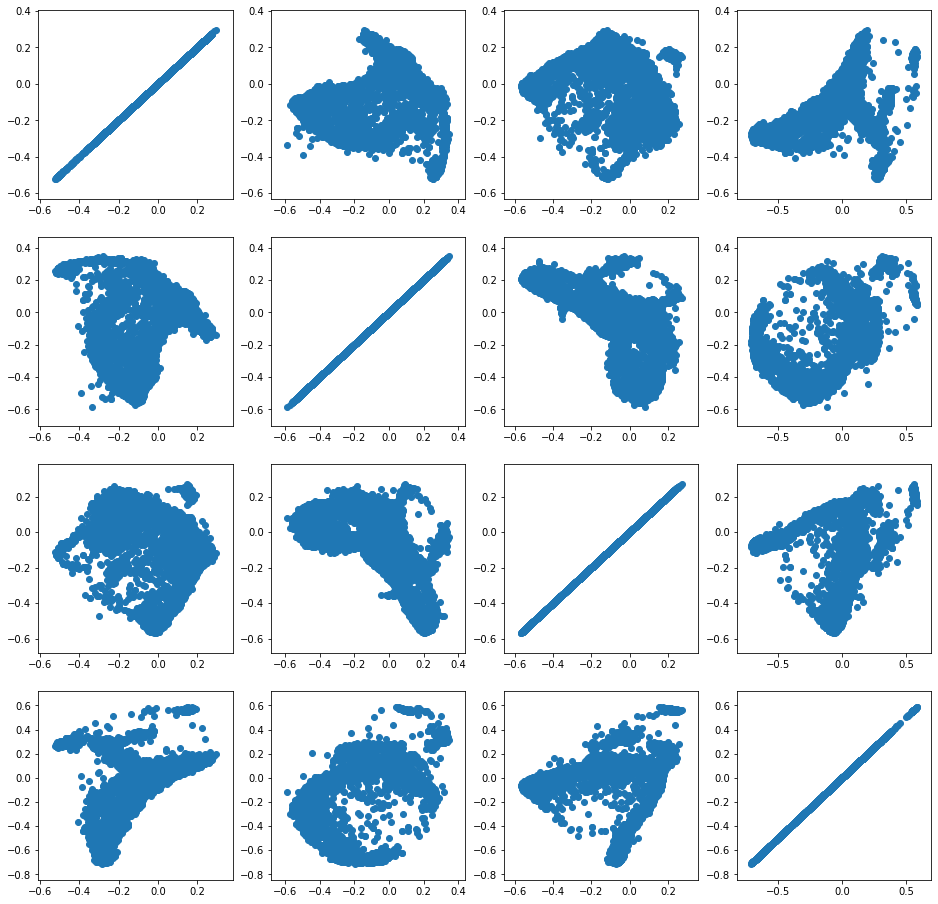

In [85]:
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,1+i+4*j)
        plt.scatter(latents[:,i], latents[:,j])

plt.gcf().set_size_inches((16,16))
plt.show()

In [7]:
import umap

clf = umap.UMAP(n_components=2, min_dist = 0.125)

ulatents = clf.fit_transform(latents)

In [8]:
ulatents.shape[0]

16000

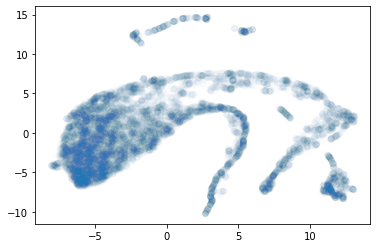

In [12]:
plt.scatter(ulatents[:,0], ulatents[:,1], alpha=0.01)
plt.show()

In [46]:
# Getting sequences

net.eval()
lseqs = []

with torch.no_grad():
    for i in range(1200):
        if i%10 == 0:
            print(i)
        x1 = getSequence(i,N=32)
        
        INITS = x1.shape[0]
        FRAMES = x1.shape[1]
        
        x1 = x1.reshape((INITS*FRAMES, x1.shape[2], x1.shape[3], x1.shape[4], x1.shape[5]))
        
        z1 = net.forward(tovar(x1)).cpu().detach().numpy()
        #z1 = clf.transform(z1)
        z1 = z1.reshape((INITS,FRAMES,z1.shape[1])).mean(axis=0)
        lseqs.append(z1[np.newaxis,:,:])

    lseqs = np.array(lseqs)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190


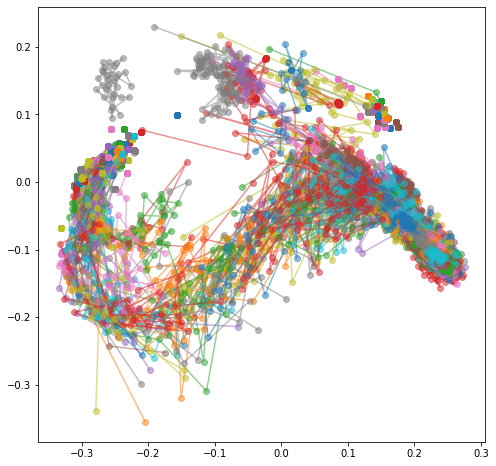

In [47]:
for i in range(lseqs.shape[0]):
    plt.plot(lseqs[i,0,1:,0], lseqs[i,0,1:,1],'o-', alpha=0.5)
    
plt.gcf().set_size_inches((8,8))
plt.show()

In [48]:
lseqs.shape

(1200, 1, 32, 16)

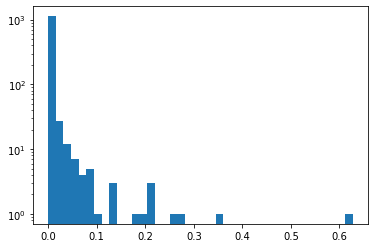

In [49]:
plt.hist(np.sum((lseqs[:,0,-10,:]-lseqs[:,0,-1,:])**2,axis=1),40)
plt.yscale("log")
plt.show()

In [51]:
idx.shape[0]

9

In [50]:
idx = np.where(np.sum((lseqs[:,0,-10,:]-lseqs[:,0,-1,:])**2,axis=1)>0.15)[0]

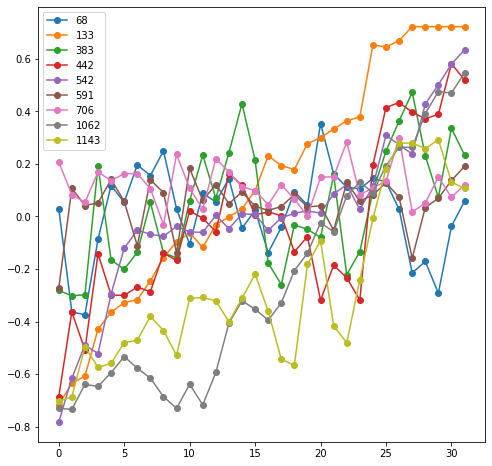

In [57]:
vdir = lseqs[:,0,-1,:] - lseqs[:,0,2,:]
vdir = vdir/np.sqrt(np.sum(vdir**2,axis=1,keepdims=True))

for i in idx:
    plt.plot(np.sum(lseqs[i,0,:,:]*vdir[i],axis=1),'o-', alpha=1, label="%d" % i)
    
plt.legend()
plt.gcf().set_size_inches((8,8))
plt.show()    

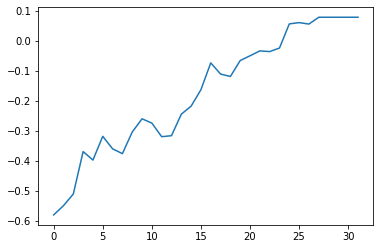

In [45]:
i = idx[1]
plt.plot(lseqs[i,0,:,4])
plt.show()

In [24]:
def canonicalize(im):
    iim = (256*im[:,:,0]).astype(np.int32) + 256*(256*im[:,:,1]).astype(np.int32) + 256*256*(256*im[:,:,2]).astype(np.int32)
    colors = np.unique(iim)
    counts = np.array([ np.sum(iim == colors[i]) for i in range(colors.shape[0])])
    reidx = np.argsort(-counts)
    colors = colors[reidx]
    
    idx = np.zeros((iim.shape[0], iim.shape[1]))
    for i in range(colors.shape[0]):
        match = 1.0*(iim==colors[i])
        idx = idx*(1-match) + i*match
    idx = idx.astype(np.int32)
    
    rgbset = np.array([
        [0,0,0],
        [1,1,1],
        [1,0,0],
        [0,1,0],
        [0,0,1],
        [1,0,1],
        [0,1,1],
        [1,1,0]
    ])    
    
    newim = rgbset[idx]
    
    return newim

(2, 81, 3, 32, 32, 32)


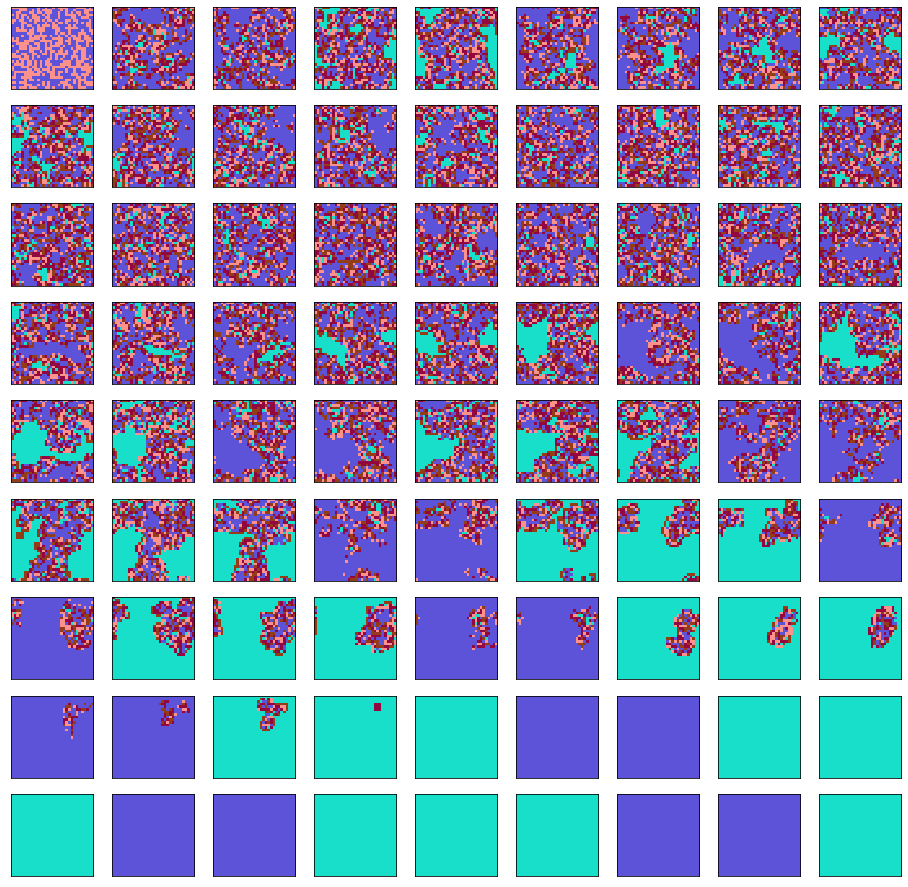

In [66]:
stack = getSequence(1062,81)
print(stack.shape)
for i in range(81):
    t = i
    plt.subplot(9,9,1+i)    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(0.5 + 0.5 * stack[0,t,:,:,:,0].transpose(1,2,0))
    
plt.gcf().set_size_inches((16,16))
plt.gcf().set_facecolor('white')
plt.show()

In [30]:
idx[0]

68

In [ ]:
for i in range(0,ims.shape[0],2):
    plt.imshow(ims[i], extent=[ulatents[i,0], ulatents[i,0]+0.5*1.3, ulatents[i,1], ulatents[i,1]+0.5*1.3])

xmin = np.min(ulatents[:,0])
xmax = np.max(ulatents[:,0])
ymin = np.min(ulatents[:,1])
ymax = np.max(ulatents[:,1])
plt.xlim(xmin-1,xmax+1)
plt.ylim(ymin-1,ymax+1)

plt.gcf().set_size_inches((96,96))
plt.show()

In [91]:
xmin = np.min(ulatents[:,0])-1
xmax = np.max(ulatents[:,0])+1
ymin = np.min(ulatents[:,1])-1
ymax = np.max(ulatents[:,1])+1

XR = 64
YR = 64
im = np.zeros((32*XR,32*YR,3))+0.5

for x in range(XR):
    for y in range(YR):
        posx = xmin+(xmax-xmin)*(x+0.5)/XR
        posy = ymin+(ymax-ymin)*(y+0.5)/YR
        
        dist = (ulatents[:,0] - posx)**2 + (ulatents[:,1]-posy)**2
        nearest = np.argmin( dist )
        mindist = dist[nearest]
        
        if mindist<0.125:
            im[32*x:32*x+32,32*y:32*y+32,:] = canonicalize(ims2[nearest])

im = np.clip(256*im,0,255).astype(np.uint8)
im = Image.fromarray(im)
im.save("ca2d_embedding2.png")

In [ ]:
np.min(latents)

In [10]:
import pickle

In [11]:
pickle.dump(clf, open("umap_classifier.pkl","wb"))